# Extrinsics Calibration - DD24 - Real World scenario

In [3]:
%load_ext autoreload
%autoreload 2



import matplotlib.pyplot as plt

from dt_computer_vision.camera import Pixel

from dt_computer_vision.camera.calibration.extrinsics.chessboard import find_corners
from dt_computer_vision.camera.calibration.extrinsics.rendering import draw_corners
from dt_computer_vision.camera.calibration.extrinsics.ransac import estimate_homography

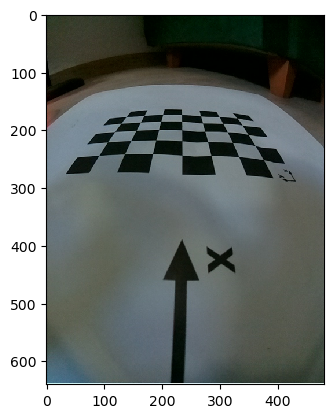

In [4]:
import os
import cv2
import numpy as np

from typing import List


from dt_computer_vision.camera import CameraModel
from dt_computer_vision.camera.calibration.extrinsics.boards import CalibrationBoardDD24

this_dir: str = os.path.abspath("")
assets_dir: str = os.path.join(this_dir, "..", "assets")
image_fpath: str = os.path.join(assets_dir, "extrinsics/dd24/real-world/scenario0/image-0.png")
image: np.ndarray = cv2.imread(image_fpath)
board = CalibrationBoardDD24

# Load camera model from YAML file
yaml_file = os.path.join(
    assets_dir,
    "extrinsics",
    "dd24",
    "real-world",
    "scenario0",
    "calibration-intrinsic-dd24.yaml",
)

with open(yaml_file, "r") as file:
    yaml_content = file.read()
    camera = CameraModel.from_ros_calibration(yaml_content)
    
assert image.shape == (camera.height, camera.width, 3), f"Image shape: {image.shape}, Camera shape: {*camera.get_shape(), 3}"

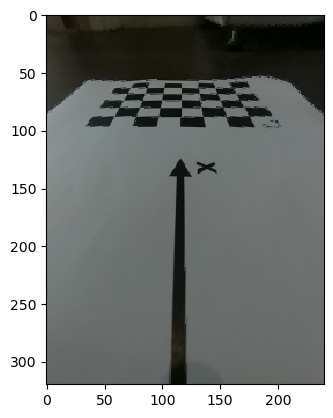

In [5]:
# rectify image
image_rect = camera.rectifier.rectify(image)
rectified = cv2.cvtColor(image_rect, cv2.COLOR_BGR2RGB)
plt.imshow(rectified)

In [6]:
# find corners
corners: List[Pixel] = find_corners(image_rect, board)
print(f"Found {len(corners)} corners.")
assert len(corners) == (board.columns) * (board.rows)

Found 35 corners.


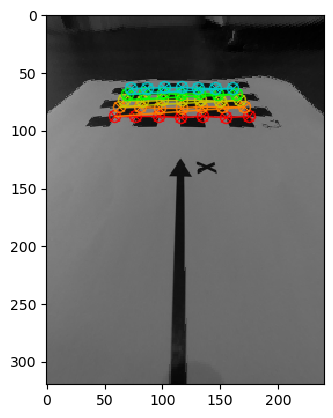

In [7]:
# draw detected corners on top of the image
image_w_corners = draw_corners(image_rect, board, corners)
image_w_corners_rgb = cv2.cvtColor(image_w_corners, cv2.COLOR_BGR2RGB)
plt.imshow(image_w_corners_rgb)

In [6]:
# estimate homography
H = estimate_homography(corners, board, camera)

In [7]:
from dt_computer_vision.camera.homography import HomographyToolkit


print(H.flatten().tolist())

# Save homography to YAML file
homography_file = os.path.join(
    assets_dir,
    "extrinsics",
    "dd24",
    "real-world",
    "scenario0",
    "homography.yaml",
)
HomographyToolkit.save_to_disk(H, homography_file)

[0.076864957720595, 0.04804079335448343, 0.047973539918674216, 0.0002359212384708009, 0.19805101798373, 0.10400177075273405, 0.03196671701892474, 0.915595543029602, 1.0]


# Ground Reprojection

In [8]:
from typing import List
from dt_computer_vision.camera.calibration.extrinsics.chessboard import get_ground_corners_and_error, compute_placement_error

from dt_computer_vision.camera import NormalizedImagePoint
from dt_computer_vision.ground_projection import GroundPoint

image_corners: List[NormalizedImagePoint]
ground_corners: List[GroundPoint]
ground_corners_projected: List[GroundPoint]
errors: List[float]

image_corners, ground_corners, ground_corners_projected, errors = get_ground_corners_and_error(camera, corners, board, H)

for i, (image_corner, ground_corner, ground_corner_projected, error) in enumerate(zip(image_corners, ground_corners, ground_corners_projected, errors)):
    # print out (image point, ground computed, and ground oracle) points
    print(f"{i}\t: I[{image_corner}] -> Gc[{ground_corner_projected}] ~ G[{ground_corner}]: {float(error):.4f}m")

# compute average error
avg_error = np.average(errors)
std_error = np.std(errors)
print(f"Overall error: {avg_error:.4f}m +/- {std_error:.4f}m")

# find all corners that are on the X and Y axis of the calibration pattern (the lines partitioning the board into 4 equal quadrants)
placement_error: float = compute_placement_error(corners, board, errors)
print(f"Placement error: {placement_error:.4f}m")

0	: I[P(0.4188, -0.4715)] -> Gc[P(0.3154, 0.0632)] ~ G[P(0.316, 0.063)]: 0.0007m
1	: I[P(0.2914, -0.4671)] -> Gc[P(0.3171, 0.0428)] ~ G[P(0.316, 0.043)]: 0.0011m
2	: I[P(0.1621, -0.4693)] -> Gc[P(0.3164, 0.0225)] ~ G[P(0.316, 0.023)]: 0.0006m
3	: I[P(0.038, -0.4668)] -> Gc[P(0.3174, 0.0029)] ~ G[P(0.316, 0.003)]: 0.0014m
4	: I[P(-0.0859, -0.474)] -> Gc[P(0.3148, -0.017)] ~ G[P(0.316, -0.017)]: 0.0012m
5	: I[P(-0.2132, -0.4693)] -> Gc[P(0.3167, -0.0372)] ~ G[P(0.316, -0.037)]: 0.0007m
6	: I[P(-0.3332, -0.4723)] -> Gc[P(0.3156, -0.0567)] ~ G[P(0.316, -0.057)]: 0.0005m
7	: I[P(0.3908, -0.5221)] -> Gc[P(0.2946, 0.0634)] ~ G[P(0.296, 0.063)]: 0.0014m
8	: I[P(0.2727, -0.5218)] -> Gc[P(0.2948, 0.0432)] ~ G[P(0.296, 0.043)]: 0.0012m
9	: I[P(0.1504, -0.5209)] -> Gc[P(0.2953, 0.0222)] ~ G[P(0.296, 0.023)]: 0.0011m
10	: I[P(0.0402, -0.5191)] -> Gc[P(0.2961, 0.0032)] ~ G[P(0.296, 0.003)]: 0.0002m
11	: I[P(-0.0777, -0.5187)] -> Gc[P(0.2963, -0.0171)] ~ G[P(0.296, -0.017)]: 0.0004m
12	: I[P(-0.1918,